# Medical Image Classification with PyHealth

Welcome to the PyHealth tutorial on image classification. In this notebook, we will explore how to use PyHealth to analyze chest X-ray images and classify them into various chest diseases. We will then look at saliency maps of the classified images.

## Environment Setup

To begin, we need to install PyHealth and a few additional packages to support our analysis.

In [1]:
!pip install mne pandarallel rdkit transformers

In [2]:
!rm -rf PyHealth-fitzpa15
# !git clone https://github.com/sunlabuiuc/PyHealth.git
!git clone -b SaliencyMappingGradient https://github.com/Nimanui/PyHealth-fitzpa15.git

Cloning into 'PyHealth-fitzpa15'...
remote: Enumerating objects: 7176, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 7176 (delta 101), reused 48 (delta 45), pack-reused 7029 (from 2)
Receiving objects: 100% (7176/7176), 113.70 MiB | 27.60 MiB/s, done.
Resolving deltas: 100% (4519/4519), done.


In [3]:
%pip install -e ./PyHealth-fitzpa15

Obtaining file:///opt/workspace/PyHealth-fitzpa15/examples/PyHealth-fitzpa15
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for pyhealth (pyproject.toml) ... done
  Created wheel for pyhealth: filename=pyhealth-2.0-py3-none-any.whl size=10697 sha256=4edbd5bb63c3a577a1ed73a93b45e467b35099d87f0224bee74d82c0537d9f0d
  Stored in directory: /tmp/pip-ephem-wheel-cache-txi14dmg/wheels/ca/57/4e/7c7f6e72111fb8281ba959fb40451bc7dc3b1e20a7606730e2
Successfully built pyhealth
  Attempting uninstall: pyhealth
    Found existing installation: pyhealth 2.0
    Uninstalling pyhealth-2.0:
      Successfully uninstalled pyhealth-2.0
Note: you may need to restart the kernel to use updated packages.


In [4]:
import sys


sys.path.append("./pyHealth")
sys.path.append("./pyhealth-fitzpa15")
sys.path.append("./PyHealth")
sys.path.append("./Pyhealth-fitzpa15")

## Download Data

Next, we will download the dataset containing COVID-19 data. This dataset includes chest X-ray images of normal cases, lung opacity, viral pneumonia, and COVID-19 patients. You can find more information about the dataset [here](https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database).

This dataset is hosted on Google Cloud, so the download speed should be relatively fast, taking approximately 10 seconds to complete.

In [5]:
!wget -N https://storage.googleapis.com/pyhealth/covid19_cxr_data/archive.zip

--2025-10-05 19:17:20--  https://storage.googleapis.com/pyhealth/covid19_cxr_data/archive.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.4.91, 172.217.4.219, 172.217.4.59, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.4.91|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘archive.zip’ not modified on server. Omitting download.



In [6]:
!unzip -q -o archive.zip

In [7]:
!ls -1 COVID-19_Radiography_Dataset

COVID
COVID.metadata.xlsx
Lung_Opacity
Lung_Opacity.metadata.xlsx
Normal
Normal.metadata.xlsx
README.md.txt
'Viral Pneumonia'
'Viral Pneumonia.metadata.xlsx'
covid19_cxr-metadata-pyhealth.csv


Next, we will proceed with the chest X-ray classification task using PyHealth, following a five-stage pipeline.

## Step 1. Load Data in PyHealth

The initial step involves loading the data into PyHealth's internal structure. This process is straightforward: import the appropriate dataset class from PyHealth and specify the root directory where the raw dataset is stored. PyHealth will handle the dataset processing automatically.

In [8]:
from pyhealth.datasets import COVID19CXRDataset


# root = "/content/COVID-19_Radiography_Dataset"
root = "COVID-19_Radiography_Dataset"
base_dataset = COVID19CXRDataset(root)

No config path provided, using default config
Initializing covid19_cxr dataset from COVID-19_Radiography_Dataset (dev mode: False)
Scanning table: covid19_cxr from /opt/workspace/PyHealth-fitzpa15/examples/COVID-19_Radiography_Dataset/covid19_cxr-metadata-pyhealth.csv


Once the data is loaded, we can perform simple queries on the dataset.

In [9]:
base_dataset.stats()

Collected dataframe with shape: (21165, 6)
Dataset: covid19_cxr
Dev mode: False
Number of patients: 21165
Number of events: 21165


## Step 2. Define the Task

The next step is to define the machine learning task. This step instructs the package to generate a list of samples with the desired features and labels based on the data for each individual patient. Please note that in this dataset, patient identification information is not available. Therefore, we will assume that each chest X-ray belongs to a unique patient.

For this dataset, PyHealth offers a default task specifically for chest X-ray classification. This task takes the image as input and aims to predict the chest diseases associated with it.

In [10]:
base_dataset.default_task

In [11]:
sample_dataset = base_dataset.set_task()

Setting task COVID19CXRClassification for covid19_cxr base dataset...
Generating samples with 1 worker(s)...


Generating samples for COVID19CXRClassification with 1 worker: 100%|██████████| 21165/21165 [00:19<00:00, 1073.21it/s]

Label disease vocab: {'COVID': 0, 'Lung Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}



Processing samples: 100%|██████████| 21165/21165 [00:46<00:00, 453.85it/s]

Generated 21165 samples for task COVID19CXRClassification


Here is an example of a single sample, represented as a dictionary. The dictionary contains keys for feature names, label names, and other metadata associated with the sample.

In [12]:
sample_dataset[0]

{'image': tensor([[[0.2902, 0.3412, 0.3569,  ..., 0.0275, 0.0078, 0.0000],
          [0.2902, 0.3412, 0.3569,  ..., 0.0196, 0.0039, 0.0000],
          [0.2863, 0.3412, 0.3569,  ..., 0.0157, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]),
 'disease': tensor(2)}

We can also check the input and output schemas, which specify the data types of the features and labels.

In [13]:
sample_dataset.input_schema

{'image': 'image'}

In [14]:
sample_dataset.output_schema

{'disease': 'multiclass'}

Below, we plot the number of samples per classes, and visualize some samples.

In [15]:
print(sample_dataset)

Sample dataset covid19_cxr <pyhealth.tasks.covid19_cxr_classification.COVID19CXRClassification object at 0x7e5ad451a420>


In [16]:
label2id = sample_dataset.output_processors["disease"].label_vocab
print(sample_dataset.output_schema)
id2label = {v: k for k, v in label2id.items()}

{'disease': 'multiclass'}


defaultdict(<class 'int'>, {'Normal': 10192, 'Lung Opacity': 6012, 'COVID': 3616, 'Viral Pneumonia': 1345})


<BarContainer object of 4 artists>

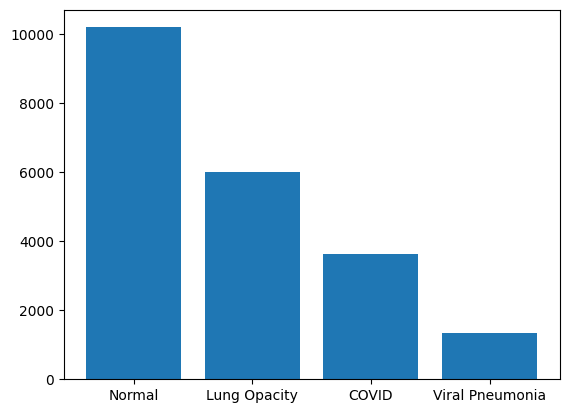

In [17]:
from collections import defaultdict
import matplotlib.pyplot as plt


label_counts = defaultdict(int)
for sample in sample_dataset.samples:
    label_counts[id2label[sample["disease"].item()]] += 1
print(label_counts)
plt.bar(label_counts.keys(), label_counts.values())

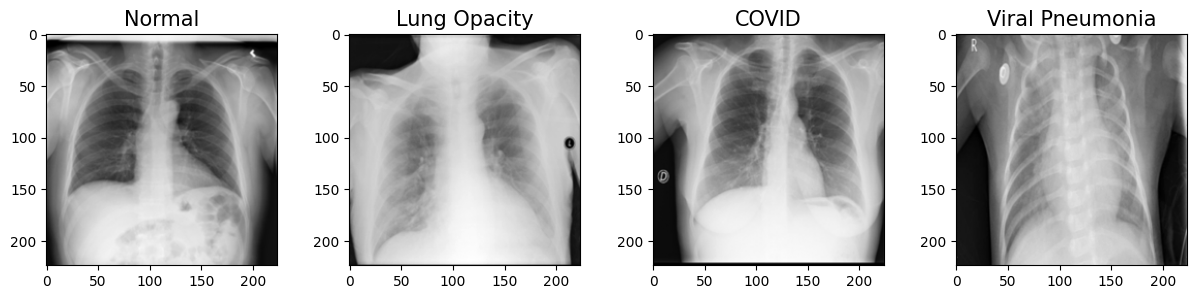

In [18]:
import random

label_to_idxs = defaultdict(list)
for idx, sample in enumerate(sample_dataset.samples):
    label_to_idxs[sample["disease"].item()].append(idx)

fig, axs = plt.subplots(1, 4, figsize=(15, 3))
for ax, label in zip(axs, label_to_idxs.keys()):
    ax.set_title(id2label[label], fontsize=15)
    idx = random.choice(label_to_idxs[label])
    sample = sample_dataset[idx]
    image = sample["image"][0]
    ax.imshow(image, cmap="gray")

Finally, we will split the entire dataset into training, validation, and test sets using the ratios of 70%, 10%, and 20%, respectively. We will then obtain the corresponding data loaders for each set.

In [19]:
from pyhealth.datasets import split_by_sample


train_dataset, val_dataset, test_dataset = split_by_sample(
    dataset=sample_dataset,
    ratios=[0.7, 0.1, 0.2]
)

In [20]:
from pyhealth.datasets import get_dataloader


train_dataloader = get_dataloader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = get_dataloader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = get_dataloader(test_dataset, batch_size=32, shuffle=False)

## Step 3. Define the Model

Next, we will define the deep learning model we want to use for our task. PyHealth supports all major vision models available in the Torchvision package. You can load any of these models using the model_name argument.

In [21]:
from pyhealth.models import TorchvisionModel


resnet = TorchvisionModel(
    dataset=sample_dataset,
    model_name="resnet18",
    model_config={"weights": "DEFAULT"}
)

resnet

/opt/workspace/PyHealth-fitzpa15/examples/PyHealth-fitzpa15/pyhealth/sampler/sage_sampler.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/opt/workspace/PyHealth-fitzpa15/examples/PyHealth-fitzpa15/pyhealth/metrics/calibration.py:102: SyntaxWarning: invalid escape sequence '\c'
  """Expected Calibration Error (ECE).
/opt/workspace/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TorchvisionModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [22]:
from pyhealth.models import TorchvisionModel


vit = TorchvisionModel(
    dataset=sample_dataset,
    model_name="vit_b_16",
    model_config={"weights": "DEFAULT"}
)

vit

TorchvisionModel(
  (model): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1)


## Step 4. Training


In this step, we will train the model using PyHealth's Trainer class, which simplifies the training process and provides standard functionalities.

Let us first train the ResNet model.

In [23]:
from pyhealth.trainer import Trainer


resnet_trainer = Trainer(model=resnet)

TorchvisionModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

Before we begin training, let's first evaluate the initial performance of the model.

In [24]:
print(resnet_trainer.evaluate(test_dataloader))

Evaluation: 100%|██████████| 133/133 [00:03<00:00, 37.99it/s]

{'accuracy': 0.27569099929128277, 'f1_macro': 0.1086091538818865, 'f1_micro': 0.27569099929128277, 'loss': 1.4285082888782472}


Now, let's start the training process. Due to computational constraints, we will train the model for only one epoch.

In [25]:
resnet_trainer.train(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=1,
    monitor="accuracy"
)

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7e59efec1ee0>
Monitor: accuracy
Monitor criterion: max
Epochs: 1



Epoch 0 / 1: 100%|██████████| 463/463 [00:26<00:00, 17.16it/s]

--- Train epoch-0, step-463 ---
loss: 0.3539



Evaluation: 100%|██████████| 67/67 [00:01<00:00, 51.04it/s]

--- Eval epoch-0, step-463 ---
accuracy: 0.7780
f1_macro: 0.7681
f1_micro: 0.7780
loss: 0.5976
New best accuracy score (0.7780) at epoch-0, step-463


Loaded best model


After training the model, we can compare its performance before and after. We should expect to see an increase in the accuracy score as the model learns from the training data.

## Step 5. Evaluation

Lastly, we can eavluate the ResNet model on the test set. This can be done using PyHealth's `Trainer.evaluate()` function.

In [26]:
print(resnet_trainer.evaluate(test_dataloader))

Evaluation: 100%|██████████| 133/133 [00:02<00:00, 52.39it/s]

{'accuracy': 0.7902197023387668, 'f1_macro': 0.7830676925495026, 'f1_micro': 0.7902197023387668, 'loss': 0.5506138118137991}


Additionally, you can perform inference using the `Trainer.inference()` function.

In [27]:
y_true, y_prob, loss = resnet_trainer.inference(test_dataloader)
y_pred = y_prob.argmax(axis=1)

Evaluation: 100%|██████████| 133/133 [00:02<00:00, 51.44it/s]


Below we show a confusion matrix of the trained ResNet model.

Text(50.722222222222214, 0.5, 'True')

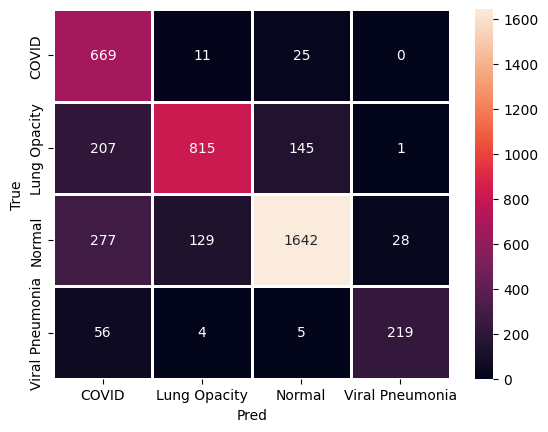

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


cf_matrix = confusion_matrix(y_true, y_pred)
ax = sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='g')
ax.set_xticklabels([id2label[i] for i in range(4)])
ax.set_yticklabels([id2label[i] for i in range(4)])
ax.set_xlabel("Pred")
ax.set_ylabel("True")

# 6 Gradient Saliency Mapping
For a bonus let's look at some simple gradient saliency maps applied to our sample dataset.

In [29]:
def add_requires_grad(in_dataset):
  for sample in in_dataset:
    sample['image'].requires_grad_()

In [30]:
from pyhealth.datasets import get_dataloader
from pyhealth.interpret.methods.saliency import GradientSaliencyMapping
batch_size = 32

sample_dataloader = get_dataloader(sample_dataset.samples, batch_size=batch_size, shuffle=True)

saliency_maps = GradientSaliencyMapping(resnet, sample_dataloader, 20)

In [31]:
import torchvision
import numpy as np

def imshow(img, title):
    npimg = img.numpy()
    plt.figure(figsize=(15, 7))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

def imshowSaliencyCompFromDict(saliency_dict_list, batch_index, image_index, title, alpha=0.3):
    img = saliency_dict_list[batch_index]['image'][image_index]
    saliency = saliency_dict_list[batch_index]['saliency'][image_index]
    label = saliency_dict_list[batch_index]['label'][image_index]
    new_title = str(title + " " + id2label[label.item()])
    imshowSaliencyComp(img, saliency, new_title, alpha)

def imshowSaliencyComp(img, saliency, title, alpha=0.3):
    npimg = img.detach().numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    plt.figure(figsize=(15, 7))
    plt.axis('off')
    plt.imshow(npimg.squeeze(), cmap='gray')
    plt.imshow(saliency, cmap='hot', alpha=alpha)
    plt.title(title)
    plt.show()

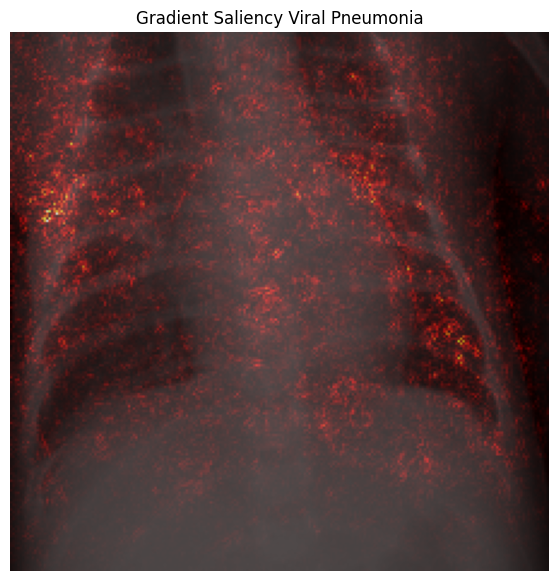

In [33]:
batch_count = int(len(saliency_maps[0])/3)
batch_size = len(saliency_maps[0]['saliency'])
batch_random = random.randint(0, batch_count - 1)
image_index_random = random.randint(0, batch_size - 1)
imshowSaliencyCompFromDict(saliency_maps, batch_random, image_index_random, "Gradient Saliency", .6)